# Task for Today  

***

## Credit Card Default Prediction  

Given *data about credit card clients*, let's try to predict whether a given client will **default** or not.  
  
We will use logistic regression, support vector machine, and neural network models to make our predictions.

# Getting Started

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#THESE LIBRARIES ARE FOR THE NEURAL NETWORK IMPLEMENTATION 
import keras
import tensorflow as tf

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics as ks_metrics
from keras.utils.np_utils import to_categorical

#WE NEED THIS FUNCTION FOR THE LIFT CURVE IMPLEMENTATION
from lift_curve_def import lift_curve

# Lift Curve Implementation

In [ ]:
def lift_curve(probabilities, title = "Model"):

    #First, sort the probabilities in decreasing order
    probabilities = -1*np.sort(-1*probabilities)
    N = np.shape(probabilities)[0]

    #Now, build the three curves for the graph like in the paper
    lift_curve_values = [sum(probabilities[0:(i+1)]) for i in range(N)]
    baseline_values = [((i+1)/N)*lift_curve_values[-1] for i in range(N)]
    best_values = [min(i+1,lift_curve_values[-1]) for i in range(N)]

    #Compute the area between the model curve and the baseline curve
    lift_area = sum([lift_curve_values[i] - baseline_values[i] for i in range(N)])
    best_area = sum([best_values[i] - baseline_values[i] for i in range(N)])
    area_ratio = lift_area/best_area

    print("The area ratio is %s"%(area_ratio))

    plt.title("Lift Curve for %s"%(title))
    plt.xlabel("# of total data points")
    plt.ylabel("# of target data points")

    plt.plot(baseline_values)
    plt.plot(best_values)
    plt.plot(lift_curve_values)

    plt.legend(["Baseline Model","Theoretically Best Model", "Actual Model"])


In [24]:
data = pd.read_excel("default of credit card clients.xls", header=1)
print(data.columns)
print(data.info())

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-nul

# Visualization

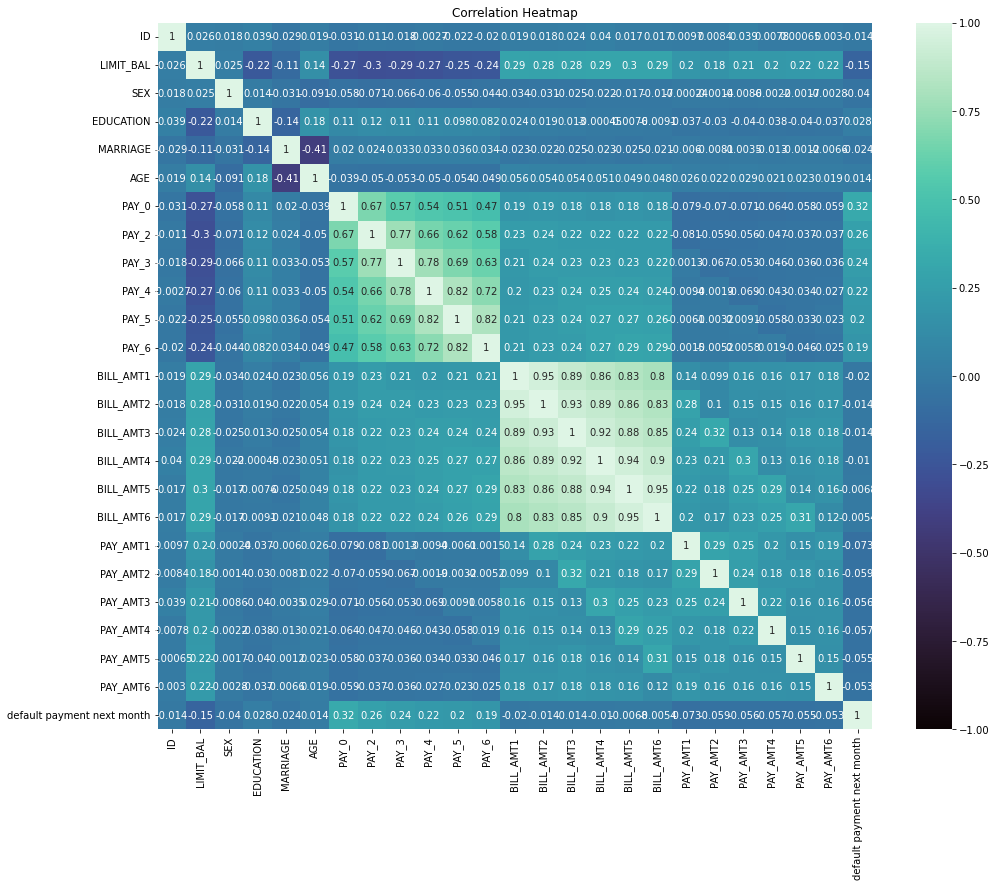

In [25]:
corr = data.corr()
plt.figure(figsize=(16, 13))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title("Correlation Heatmap")
plt.show()

# Preprocessing

In [26]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [27]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop ID
    df = df.drop('ID', axis=1)
    
    df = onehot_encode(
        df,
        {
            'EDUCATION': 'EDU',
            'MARRIAGE': 'MAR'
        }
    )
    
    # Split df into X and y
    #y = df['default.payment.next.month'].copy()
    y = df['default payment next month'].copy()
    X = df.drop('default payment next month', axis=1).copy()
    #X = df.drop('default.payment.next.month', axis=1).copy()
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, y

In [28]:
X, y = preprocess_inputs(data)

In [29]:
X

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,EDU_1,EDU_2,EDU_3,EDU_4,EDU_5,EDU_6,MAR_0,MAR_1,MAR_2,MAR_3
0,-1.136720,0.810161,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326
1,-0.365981,0.810161,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326
2,-0.597202,0.810161,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.298560,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326
3,-0.905498,0.810161,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326
4,-0.905498,-1.234323,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,-0.578618,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.404759,-1.234323,0.381275,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,1.870379,...,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326
29996,-0.134759,-1.234323,0.815221,-0.874991,-0.723570,-0.696663,-0.666599,0.234917,0.253137,-0.672786,...,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326
29997,-1.059646,-1.234323,0.164303,3.574267,2.617654,1.809921,-0.666599,0.234917,0.253137,-0.647227,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326
29998,-0.674276,-1.234323,0.598248,0.904712,-0.723570,0.138865,0.188746,0.234917,-0.616452,-0.717982,...,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326


In [30]:
y

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default payment next month, Length: 30000, dtype: int64

In [31]:
{column: len(X[column].unique()) for column in X.columns}

{'LIMIT_BAL': 81,
 'SEX': 2,
 'AGE': 56,
 'PAY_0': 11,
 'PAY_2': 11,
 'PAY_3': 11,
 'PAY_4': 11,
 'PAY_5': 10,
 'PAY_6': 10,
 'BILL_AMT1': 22723,
 'BILL_AMT2': 22346,
 'BILL_AMT3': 22026,
 'BILL_AMT4': 21548,
 'BILL_AMT5': 21010,
 'BILL_AMT6': 20604,
 'PAY_AMT1': 7943,
 'PAY_AMT2': 7899,
 'PAY_AMT3': 7518,
 'PAY_AMT4': 6937,
 'PAY_AMT5': 6897,
 'PAY_AMT6': 6939,
 'EDU_0': 2,
 'EDU_1': 2,
 'EDU_2': 2,
 'EDU_3': 2,
 'EDU_4': 2,
 'EDU_5': 2,
 'EDU_6': 2,
 'MAR_0': 2,
 'MAR_1': 2,
 'MAR_2': 2,
 'MAR_3': 2}

# Logistic Regression Model

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

In [182]:
# Create and fit the logistic regression model
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Print the models coefficients
print(clf_logistic.coef_)

[[-0.07391066 -0.06560366  0.04594474  0.62643679  0.09439256  0.09760826
  -0.00669273  0.04729133  0.04005348 -0.44708577  0.16862924  0.08105853
   0.08402481  0.08488268 -0.05676865 -0.21457128 -0.25493799 -0.1067462
  -0.06520911 -0.0171216  -0.04046545 -0.13131492  0.03887616 -0.00378487
   0.00351637 -0.0587529  -0.11357256 -0.01162902 -0.02901006  0.04457416
  -0.04294613  0.00446232]]


[[0.88733199 0.11266801]
 [0.76115198 0.23884802]
 [0.4939395  0.5060605 ]
 ...
 [0.50378583 0.49621417]
 [0.87468848 0.12531152]
 [0.85198579 0.14801421]]
The model accuracy is 81.51666666666667%


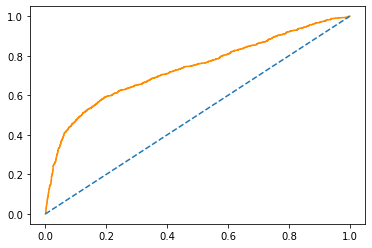

0.7336868409088534

In [186]:
# Create predictions and store them in a variable
preds = clf_logistic.predict_proba(X_test)
print(preds)
# Print the accuracy score the model
print("The model accuracy is %s%%"%(100*clf_logistic.score(X_test, y_test)))

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = metrics.roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = metrics.roc_auc_score(y_test, prob_default)
auc

The area ratio is 0.4536739450225643


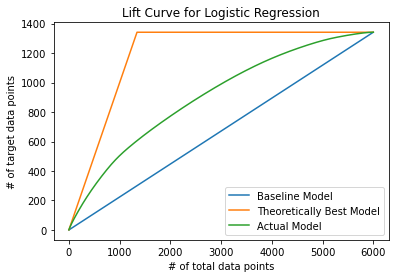

In [185]:
lift_curve(np.reshape(preds[:,1],(6000,)), "Logistic Regression")

# Neural Networks

In [36]:
#First, create the model
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape=(32,)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


In [37]:
#Now, compile the model
model.compile(optimizer='rmsprop', 
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [38]:
#We are ready to train the model!
n_epochs = 100
batch_size = 512
X_train, X_test, y_train, y_test
history = model.fit(X_train, y_train,
                       epochs = n_epochs,
                       batch_size = batch_size,
                       validation_data = (X_test, y_test))

Epoch 1/100
47/47 [==============================] - 1s 7ms/step - loss: 0.5019 - accuracy: 0.7951 - val_loss: 0.4630 - val_accuracy: 0.8088
Epoch 2/100
47/47 [==============================] - 0s 3ms/step - loss: 0.4614 - accuracy: 0.8106 - val_loss: 0.4556 - val_accuracy: 0.8122
Epoch 3/100
47/47 [==============================] - 0s 3ms/step - loss: 0.4514 - accuracy: 0.8130 - val_loss: 0.4451 - val_accuracy: 0.8140
Epoch 4/100
47/47 [==============================] - 0s 3ms/step - loss: 0.4450 - accuracy: 0.8160 - val_loss: 0.4411 - val_accuracy: 0.8125
Epoch 5/100
47/47 [==============================] - 0s 3ms/step - loss: 0.4411 - accuracy: 0.8180 - val_loss: 0.4388 - val_accuracy: 0.8157
Epoch 6/100
47/47 [==============================] - 0s 4ms/step - loss: 0.4382 - accuracy: 0.8198 - val_loss: 0.4386 - val_accuracy: 0.8160
Epoch 7/100
47/47 [==============================] - 0s 5ms/step - loss: 0.4358 - accuracy: 0.8198 - val_loss: 0.4343 - val_accuracy: 0.8157
Epoch 8/100
4

In [39]:
y_pred = model.predict(X_test)

188/188 [==============================] - 0s 1ms/step


The area ratio is 0.6394646169197914


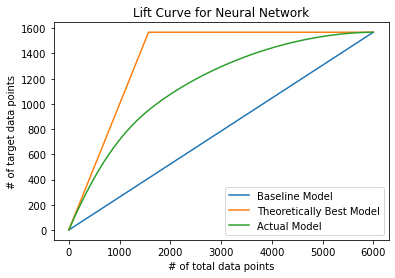

In [40]:
lift_curve(np.reshape(y_pred,(6000,)), "Neural Network")

## More Advanced Neural Network

To work with the partially sequential structure of the data, I'm going to pre-process the data a bit more.

In [168]:
X_train_NN = X_train.copy()
y_train_NN = y_train.copy()

X_test_NN = X_test.copy()
y_test_NN = y_test.copy()

In [169]:
desired_column_order = [
    'LIMIT_BAL',
    'SEX',
    'AGE',
    'EDU_0',
    'EDU_1',
    'EDU_2',
    'EDU_3',
    'EDU_4',
    'EDU_5',
    'EDU_6',
    'MAR_0',
    'MAR_1',
    'MAR_2',
    'MAR_3',
    'PAY_6',
    'PAY_5',
    'PAY_4',
    'PAY_3',
    'PAY_2',
    'PAY_0',
    'BILL_AMT6',
    'BILL_AMT5',
    'BILL_AMT4',
    'BILL_AMT3',
    'BILL_AMT2',
    'BILL_AMT1',
    'PAY_AMT6',
    'PAY_AMT5',
    'PAY_AMT4',
    'PAY_AMT3',
    'PAY_AMT2',
    'PAY_AMT1'
]

X_train_NN = X_train_NN[desired_column_order]

X_train_NN = np.array(X_train_NN).reshape(-1,32,1)
y_train_NN = np.array(y_train_NN).reshape(-1,1,1)

X_test_NN = np.array(X_test_NN).reshape(-1,32,1)
y_test_NN = np.array(y_test_NN).reshape(-1,1,1)

### Custom Model Definition

The structure is inspired by: https://www.youtube.com/watch?v=cKMJDkWSDnY

In [173]:
class MyModel(keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = layers.Dense(64, activation= 'relu')
        self.dense2 = layers.Dense(1, activation = 'sigmoid')

        self.pay_RNN = layers.SimpleRNN(input_shape = (1,6), units = 64)
        self.bill_RNN = layers.SimpleRNN(input_shape = (1,6), units = 64)
        self.pmt_RNN = layers.SimpleRNN(input_shape = (1,6), units = 64)

        self.flatten = layers.Flatten()
        self.concat = layers.Concatenate(axis=1)

    def call(self, input_tensor):
        
        #First, pass the sequential parts of the data through RNNs
        pay_rnn_input = input_tensor[:,14:20,:]
        bill_rnn_input = input_tensor[:,20:26,:]
        pmt_rnn_input = input_tensor[:,26:32,:]

        beginning_stuff = input_tensor[:,:14,:]

        pay_rnn_output = self.pay_RNN(pay_rnn_input)
        bill_rnn_output = self.bill_RNN(bill_rnn_input)
        pmt_rnn_output = self.pmt_RNN(pmt_rnn_input)
        flat_stuff = self.flatten(beginning_stuff)

        concat_stuff = self.concat([flat_stuff, pay_rnn_output, bill_rnn_output, pmt_rnn_output])
        
        return self.dense2(self.dense1(concat_stuff))

In [174]:
model = MyModel()
model.compile(optimizer='rmsprop', 
            loss='binary_crossentropy',
            metrics=['accuracy'])
model.predict(X_train_NN)
model.summary()

750/750 [==============================] - 2s 1ms/step
Model: "my_model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_92 (Dense)            multiple                  13248     
                                                                 
 dense_93 (Dense)            multiple                  65        
                                                                 
 simple_rnn_126 (SimpleRNN)  multiple                  4224      
                                                                 
 simple_rnn_127 (SimpleRNN)  multiple                  4224      
                                                                 
 simple_rnn_128 (SimpleRNN)  multiple                  4224      
                                                                 
 flatten_16 (Flatten)        multiple                  0         
                                                                 


In [175]:
#We are ready to train the model!
n_epochs = 100
batch_size = 512
X_train_NN, X_test_NN, y_train_NN, y_test_NN
history = model.fit(X_train_NN, y_train_NN,
                       epochs = n_epochs,
                       batch_size = batch_size,
                       validation_data = (X_test_NN, y_test_NN))

Epoch 1/100
47/47 [==============================] - 4s 32ms/step - loss: 0.4693 - accuracy: 0.8030 - val_loss: 0.6030 - val_accuracy: 0.7478
Epoch 2/100
47/47 [==============================] - 1s 11ms/step - loss: 0.4435 - accuracy: 0.8152 - val_loss: 0.6261 - val_accuracy: 0.7538
Epoch 3/100
47/47 [==============================] - 1s 12ms/step - loss: 0.4393 - accuracy: 0.8180 - val_loss: 0.6113 - val_accuracy: 0.7565
Epoch 4/100
47/47 [==============================] - 1s 11ms/step - loss: 0.4368 - accuracy: 0.8188 - val_loss: 0.6675 - val_accuracy: 0.7507
Epoch 5/100
47/47 [==============================] - 1s 11ms/step - loss: 0.4351 - accuracy: 0.8180 - val_loss: 0.6276 - val_accuracy: 0.7550
Epoch 6/100
47/47 [==============================] - 0s 11ms/step - loss: 0.4329 - accuracy: 0.8204 - val_loss: 0.6191 - val_accuracy: 0.7518
Epoch 7/100
47/47 [==============================] - 1s 11ms/step - loss: 0.4313 - accuracy: 0.8201 - val_loss: 0.6571 - val_accuracy: 0.7515
Epoch 

188/188 [==============================] - 0s 1ms/step
The area ratio is 0.6853702948080577


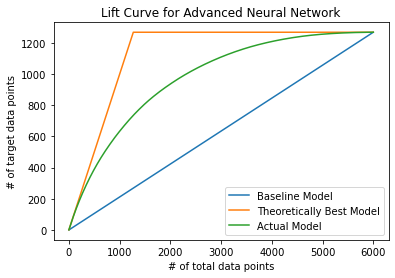

In [178]:
y_pred_NN = model.predict(X_test_NN)
lift_curve(np.reshape(y_pred_NN,(6000,)), "Advanced Neural Network")

## K-Nearest Neighbors Classifier

In [179]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)
knn = KNeighborsClassifier() 
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.7936666666666666


In [192]:
# Create predictions and store them in a variable
k_preds = knn.predict_proba(X_test)
print(k_preds)

[[0.8 0.2]
 [1.  0. ]
 [0.  1. ]
 ...
 [1.  0. ]
 [1.  0. ]
 [0.6 0.4]]


The area ratio is 0.7408061546640667


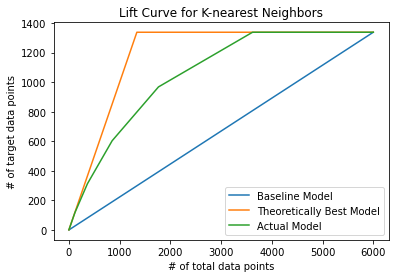

In [196]:
#plt.plot(np.sort(k_preds[:,1]))
lift_curve(np.reshape(k_preds[:,1],(6000,)), "K-nearest Neighbors")
